## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.75]
redice_lr_patient = [5, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0725 19:09:29.671471  7204 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 19:09:29.672471  7204 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 19:09:29.674471  7204 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 19:09:29.793478  7204 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5


W0725 19:09:30.073494  7204 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0725 19:09:30.085495  7204 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0725 19:09:30.188500  7204 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 5s 97us/step - loss: 0.7798 - acc: 0.7548 - val_loss: 1.4754 - val_acc: 0.5020
Epoch 48/50
50000/50000 [==============================] - 5s 96us/step - loss: 0.7787 - acc: 0.7549 - val_loss: 1.4751 - val_acc: 0.5029
Epoch 49/50
50000/50000 [==============================] - 5s 96us/step - loss: 0.7781 - acc: 0.7558 - val_loss: 1.4758 - val_acc: 0.5024
Epoch 50/50
50000/50000 [==============================] - 5s 96us/step - loss: 0.7768 - acc: 0.7551 - val_loss: 1.4756 - val_acc: 0.5010
Numbers of exp: 1, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch

50000/50000 [==============================] - 5s 109us/step - loss: 1.6494 - acc: 0.4268 - val_loss: 1.7394 - val_acc: 0.3959
Epoch 46/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.6451 - acc: 0.4284 - val_loss: 1.7356 - val_acc: 0.3983
Epoch 47/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.6402 - acc: 0.4280 - val_loss: 1.7325 - val_acc: 0.3987
Epoch 48/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.6354 - acc: 0.4313 - val_loss: 1.7297 - val_acc: 0.4002
Epoch 49/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.6319 - acc: 0.4316 - val_loss: 1.7253 - val_acc: 0.4010
Epoch 50/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.6267 - acc: 0.4334 - val_loss: 1.7220 - val_acc: 0.4036
Numbers of exp: 2, reduce_factor: 0.75, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape             

50000/50000 [==============================] - 6s 110us/step - loss: 1.6623 - acc: 0.4244 - val_loss: 1.7456 - val_acc: 0.3925
Epoch 44/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.6570 - acc: 0.4249 - val_loss: 1.7415 - val_acc: 0.3968
Epoch 45/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.6512 - acc: 0.4263 - val_loss: 1.7379 - val_acc: 0.3971
Epoch 46/50
50000/50000 [==============================] - 5s 109us/step - loss: 1.6465 - acc: 0.4280 - val_loss: 1.7339 - val_acc: 0.3977
Epoch 47/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.6420 - acc: 0.4298 - val_loss: 1.7308 - val_acc: 0.3981
Epoch 48/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.6377 - acc: 0.4308 - val_loss: 1.7273 - val_acc: 0.4014
Epoch 49/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.6325 - acc: 0.4319 - val_loss: 1.7243 - val_acc: 0.4010
Epoch 50/50
50000/50000 [==============

50000/50000 [==============================] - 6s 112us/step - loss: 1.6676 - acc: 0.4194 - val_loss: 1.7598 - val_acc: 0.3880
Epoch 42/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.6620 - acc: 0.4203 - val_loss: 1.7556 - val_acc: 0.3884
Epoch 43/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.6571 - acc: 0.4233 - val_loss: 1.7521 - val_acc: 0.3899
Epoch 44/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.6521 - acc: 0.4249 - val_loss: 1.7478 - val_acc: 0.3914
Epoch 45/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.6477 - acc: 0.4274 - val_loss: 1.7445 - val_acc: 0.3923
Epoch 46/50
50000/50000 [==============================] - 6s 113us/step - loss: 1.6426 - acc: 0.4282 - val_loss: 1.7413 - val_acc: 0.3948
Epoch 47/50
50000/50000 [==============================] - 6s 115us/step - loss: 1.6387 - acc: 0.4301 - val_loss: 1.7377 - val_acc: 0.3938
Epoch 48/50
50000/50000 [==============


Epoch 00036: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 37/50
50000/50000 [==============================] - 6s 124us/step - loss: 0.2196 - acc: 0.9595 - val_loss: 1.7679 - val_acc: 0.5259
Epoch 38/50
50000/50000 [==============================] - 6s 126us/step - loss: 0.2158 - acc: 0.9617 - val_loss: 1.7766 - val_acc: 0.5257
Epoch 39/50
50000/50000 [==============================] - 6s 126us/step - loss: 0.2140 - acc: 0.9616 - val_loss: 1.7842 - val_acc: 0.5237
Epoch 40/50
50000/50000 [==============================] - 6s 127us/step - loss: 0.2120 - acc: 0.9629 - val_loss: 1.7980 - val_acc: 0.5236
Epoch 41/50
50000/50000 [==============================] - 6s 124us/step - loss: 0.2093 - acc: 0.9638 - val_loss: 1.7983 - val_acc: 0.5261

Epoch 00041: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 42/50
50000/50000 [==============================] - 6s 124us/step - loss: 0.2043 - acc: 0.9662 - val_loss: 1.8027 - val_acc: 0.5234
Epo

50000/50000 [==============================] - 6s 120us/step - loss: 1.2705 - acc: 0.5663 - val_loss: 1.5248 - val_acc: 0.4701
Epoch 34/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.2645 - acc: 0.5682 - val_loss: 1.5205 - val_acc: 0.4695
Epoch 35/50
50000/50000 [==============================] - 6s 119us/step - loss: 1.2571 - acc: 0.5710 - val_loss: 1.5192 - val_acc: 0.4710
Epoch 36/50
50000/50000 [==============================] - 6s 118us/step - loss: 1.2498 - acc: 0.5745 - val_loss: 1.5149 - val_acc: 0.4704
Epoch 37/50
50000/50000 [==============================] - 6s 116us/step - loss: 1.2427 - acc: 0.5774 - val_loss: 1.5163 - val_acc: 0.4729
Epoch 38/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.2370 - acc: 0.5801 - val_loss: 1.5145 - val_acc: 0.4732
Epoch 39/50
50000/50000 [==============================] - 6s 117us/step - loss: 1.2311 - acc: 0.5818 - val_loss: 1.5125 - val_acc: 0.4734
Epoch 40/50
50000/50000 [==============

50000/50000 [==============================] - 6s 117us/step - loss: 1.2617 - acc: 0.5699 - val_loss: 1.5338 - val_acc: 0.4667
Epoch 32/50
50000/50000 [==============================] - 6s 119us/step - loss: 1.2549 - acc: 0.5729 - val_loss: 1.5275 - val_acc: 0.4646
Epoch 33/50
50000/50000 [==============================] - 6s 117us/step - loss: 1.2472 - acc: 0.5742 - val_loss: 1.5265 - val_acc: 0.4657
Epoch 34/50
50000/50000 [==============================] - 6s 116us/step - loss: 1.2402 - acc: 0.5796 - val_loss: 1.5273 - val_acc: 0.4665
Epoch 35/50
50000/50000 [==============================] - 6s 116us/step - loss: 1.2335 - acc: 0.5813 - val_loss: 1.5234 - val_acc: 0.4677
Epoch 36/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.2267 - acc: 0.5835 - val_loss: 1.5233 - val_acc: 0.4683
Epoch 37/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.2200 - acc: 0.5854 - val_loss: 1.5193 - val_acc: 0.4722
Epoch 38/50
50000/50000 [==============

50000/50000 [==============================] - 6s 112us/step - loss: 1.2822 - acc: 0.5588 - val_loss: 1.5288 - val_acc: 0.4653
Epoch 30/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.2748 - acc: 0.5609 - val_loss: 1.5304 - val_acc: 0.4679
Epoch 31/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.2684 - acc: 0.5636 - val_loss: 1.5248 - val_acc: 0.4700
Epoch 32/50
50000/50000 [==============================] - 5s 110us/step - loss: 1.2613 - acc: 0.5668 - val_loss: 1.5218 - val_acc: 0.4696
Epoch 33/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.2541 - acc: 0.5689 - val_loss: 1.5192 - val_acc: 0.4704
Epoch 34/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.2475 - acc: 0.5719 - val_loss: 1.5183 - val_acc: 0.4702
Epoch 35/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.2410 - acc: 0.5745 - val_loss: 1.5171 - val_acc: 0.4725
Epoch 36/50
50000/50000 [==============

50000/50000 [==============================] - 5s 108us/step - loss: 0.5142 - acc: 0.8302 - val_loss: 1.6602 - val_acc: 0.5073
Epoch 27/50
50000/50000 [==============================] - 5s 109us/step - loss: 0.4927 - acc: 0.8389 - val_loss: 1.7276 - val_acc: 0.4874

Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 28/50
50000/50000 [==============================] - 5s 110us/step - loss: 0.4221 - acc: 0.8724 - val_loss: 1.6542 - val_acc: 0.5175
Epoch 29/50
50000/50000 [==============================] - 5s 110us/step - loss: 0.4024 - acc: 0.8818 - val_loss: 1.6653 - val_acc: 0.5213
Epoch 30/50
50000/50000 [==============================] - 6s 111us/step - loss: 0.3888 - acc: 0.8861 - val_loss: 1.6711 - val_acc: 0.5163
Epoch 31/50
50000/50000 [==============================] - 5s 110us/step - loss: 0.3714 - acc: 0.8919 - val_loss: 1.6943 - val_acc: 0.5120
Epoch 32/50
50000/50000 [==============================] - 6s 111us/step - loss: 0.3585 - acc: 0.

50000/50000 [==============================] - 5s 106us/step - loss: 1.3268 - acc: 0.5426 - val_loss: 1.5588 - val_acc: 0.4609
Epoch 22/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.3116 - acc: 0.5495 - val_loss: 1.5539 - val_acc: 0.4594
Epoch 23/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.2993 - acc: 0.5523 - val_loss: 1.5498 - val_acc: 0.4631
Epoch 24/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.2863 - acc: 0.5601 - val_loss: 1.5462 - val_acc: 0.4661
Epoch 25/50
50000/50000 [==============================] - 5s 110us/step - loss: 1.2744 - acc: 0.5621 - val_loss: 1.5437 - val_acc: 0.4685
Epoch 26/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.2621 - acc: 0.5680 - val_loss: 1.5348 - val_acc: 0.4643
Epoch 27/50
50000/50000 [==============================] - 5s 110us/step - loss: 1.2506 - acc: 0.5718 - val_loss: 1.5251 - val_acc: 0.4710
Epoch 28/50
50000/50000 [==============

50000/50000 [==============================] - 6s 110us/step - loss: 1.3560 - acc: 0.5309 - val_loss: 1.5788 - val_acc: 0.4565
Epoch 20/50
50000/50000 [==============================] - 5s 110us/step - loss: 1.3413 - acc: 0.5366 - val_loss: 1.5689 - val_acc: 0.4625
Epoch 21/50
50000/50000 [==============================] - 5s 110us/step - loss: 1.3260 - acc: 0.5421 - val_loss: 1.5674 - val_acc: 0.4609
Epoch 22/50
50000/50000 [==============================] - 5s 110us/step - loss: 1.3119 - acc: 0.5480 - val_loss: 1.5604 - val_acc: 0.4601
Epoch 23/50
50000/50000 [==============================] - 5s 110us/step - loss: 1.2987 - acc: 0.5531 - val_loss: 1.5548 - val_acc: 0.4629
Epoch 24/50
50000/50000 [==============================] - 5s 109us/step - loss: 1.2862 - acc: 0.5574 - val_loss: 1.5552 - val_acc: 0.4656
Epoch 25/50
50000/50000 [==============================] - 5s 109us/step - loss: 1.2731 - acc: 0.5638 - val_loss: 1.5507 - val_acc: 0.4683
Epoch 26/50
50000/50000 [==============

50000/50000 [==============================] - 6s 111us/step - loss: 1.4636 - acc: 0.4904 - val_loss: 1.6112 - val_acc: 0.4427
Epoch 17/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.4469 - acc: 0.4983 - val_loss: 1.6010 - val_acc: 0.4438
Epoch 18/50
50000/50000 [==============================] - 5s 109us/step - loss: 1.4316 - acc: 0.5040 - val_loss: 1.5957 - val_acc: 0.4462
Epoch 19/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.4176 - acc: 0.5093 - val_loss: 1.5884 - val_acc: 0.4462
Epoch 20/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.4032 - acc: 0.5131 - val_loss: 1.5796 - val_acc: 0.4504
Epoch 21/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.3892 - acc: 0.5178 - val_loss: 1.5718 - val_acc: 0.4550
Epoch 22/50
50000/50000 [==============================] - 6s 113us/step - loss: 1.3761 - acc: 0.5238 - val_loss: 1.5735 - val_acc: 0.4509
Epoch 23/50
50000/50000 [==============

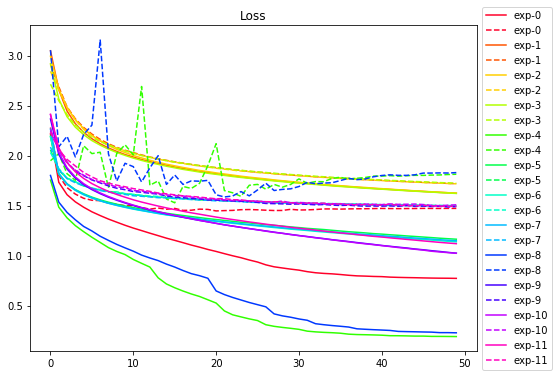

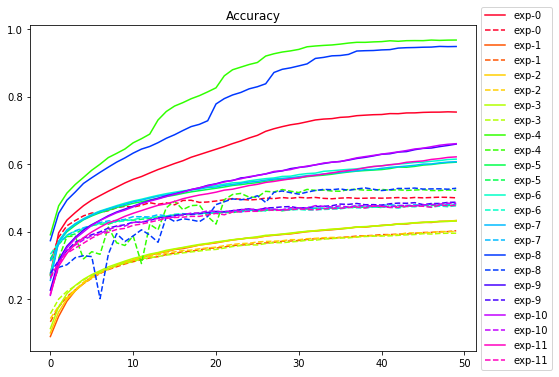

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()